# Librosa versie

In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import operator
import itertools
import os

In [7]:
def lowpass(signal, alpha):
    lowpassSig = [0] * len(signal)
    lowpassSig[0] = abs(signal[0])
    abssigTimesAlpha = alpha * np.array(abs(signal))

    for i in range(1, len(abssigTimesAlpha)):
        lowpassSig[i] = (abssigTimesAlpha[i] + (1 - alpha) * lowpassSig[i - 1])
    return lowpassSig


def getSoundThresholdFromFile(filename, start, end, alpha, thresholdfactor, fsTarget=None):
    if not fsTarget:
        signal, fsFile = librosa.load(filename, offset=start, duration=(end-start))
    else:
        signal, fsFile = librosa.load(filename, sr=fsTarget, offset=start, duration=(end-start))
    return getSoundThresholdFromSignal(signal, alpha, thresholdfactor)


def getSoundThresholdFromSignal(signal, alpha, thresholdFactor):
    lpsig = lowpass(signal, alpha)
    return thresholdFactor * np.max(lpsig)

In [8]:
def getSoundChunkIndices(signal, alpha, threshold):
    lpSig = lowpass(signal, alpha)
    indices = np.array(range(len(signal)))
    indices = indices[lpSig > threshold]

    soundIndexList = []
    for k, g in itertools.groupby(enumerate(indices), lambda i_x: i_x[0] - i_x[1]):
        soundIndexList.append(list(map(operator.itemgetter(1), g)))

    chunkIndices = []

    for chunk in soundIndexList:
        if len(chunk) > 1:
            chunkIndices.append([chunk[0], chunk[-1]])

    return chunkIndices

In [14]:
def plotSoundChunksWithParams(alpha, thresholdFactor, minimalSoundTime, filename, fsTarget=None):
    if fsTarget:
        alpha = (44100 * alpha) / fsTarget
        print('alpha: {}'.format(alpha))
        
    silenceStart = 1
    silenceEnd = 5
    soundThreshold = getSoundThresholdFromFile(filename, silenceStart, silenceEnd, alpha, thresholdFactor, fsTarget)
    print('Threshold: {}'.format(soundThreshold))
    start = 181.25
    end = start + 1

    chunks = {}
    timeChunks = []
    if not fsTarget:
        signal, framerate = librosa.load(filename, offset=start, duration=(end-start))
    else:
        signal, framerate = librosa.load(filename, sr=fsTarget, offset=start, duration=(end-start))
        
    soundChunks = getSoundChunkIndices(signal, alpha, soundThreshold)
    nr = 1

    for chunk in soundChunks:
        startTime = chunk[0] * 1.0 / framerate + start
        endTime = chunk[1] * 1.0 / framerate + start

        if endTime - startTime > minimalSoundTime:
            timeChunks.append([startTime, endTime])

    # plot figure
    fig = plt.figure()
    xs = np.array(range(len(signal))) * 1.0 / framerate + start
    plt.plot(xs, signal, '#36d81c', label='base signal')
    plt.plot(xs, lowpass(signal, alpha), 'b',linewidth='1', label='lowpass signal')
    plt.plot(xs, [soundThreshold] * len(signal), 'r', label='threshold')
    plt.plot(xs,[0] * len(signal), 'k', linewidth='1')

    # plot boundaries of chunks
    for chunk in timeChunks:
        maxVal = max(abs(signal))

        offset = 0.001 # 15
        xRectLow = chunk[0]
        rectWidth = chunk[1] - chunk[0]
        yRectLow = -maxVal - offset
        rectHeight = 2 * (maxVal + offset)
        plt.gca().add_patch(plt.Rectangle((xRectLow, yRectLow), rectWidth, rectHeight, fc='0.9'))

        plt.plot([chunk[0], chunk[0]], [-maxVal, maxVal], '0.4')
        plt.plot([chunk[1], chunk[1]], [-maxVal, maxVal], '0.4')
    plt.title('alpha: {:}, threshold factor: {:}'.format(alpha, thresholdFactor))
    plt.legend(loc='lower left')
    plt.axis('off')
    plt.show()
    print('timechunks: ')
    print(timeChunks)


Threshold: 0.0018569947710994146


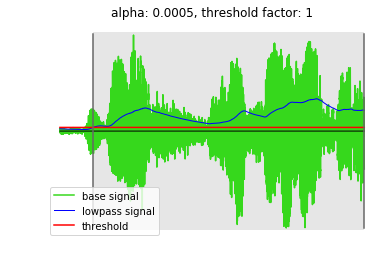

timechunks: 
[[181.3587528344671, 182.24995464852609]]
Threshold: 0.002785492156649122


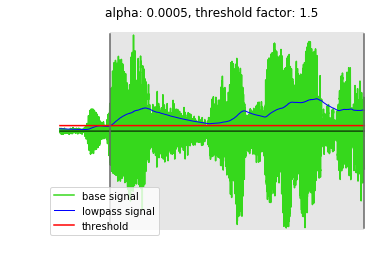

timechunks: 
[[181.4159410430839, 182.24995464852609]]
Threshold: 0.0039265783367066045


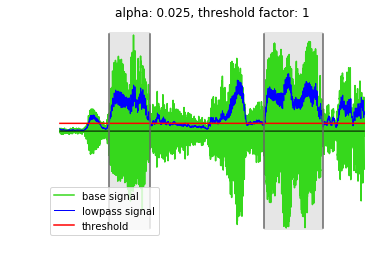

timechunks: 
[[181.41072562358278, 181.54750566893424], [181.9218820861678, 182.11272108843536]]
Threshold: 0.005889867505059907


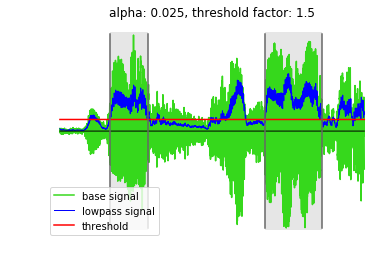

timechunks: 
[[181.41344671201813, 181.53934240362813], [181.92433106575965, 182.11095238095237]]


In [15]:
datasetDir = '../E_SAA_DATA/localizationRecordings/20160919'
filename = datasetDir + '/160919_218_mono1.wav'
minimalSoundTime = 0.1  # seconds
for alpha in [0.0005, 0.025]: #[0.00005, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05]:
    for thresholdFactor in [1, 1.5]:
        plotSoundChunksWithParams(alpha, thresholdFactor, minimalSoundTime, filename)

alpha: 0.00275625
Threshold: 0.0020973555643289984


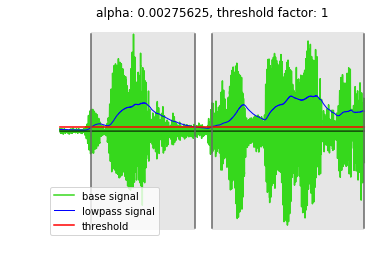

timechunks: 
[[181.353625, 181.694375], [181.7485, 182.249875]]
alpha: 0.00275625
Threshold: 0.0031460333464934974


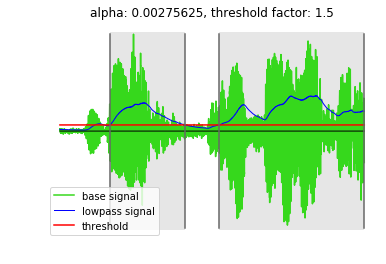

timechunks: 
[[181.414, 181.660375], [181.774125, 182.249875]]
alpha: 0.1378125
Threshold: 0.004228304390517738


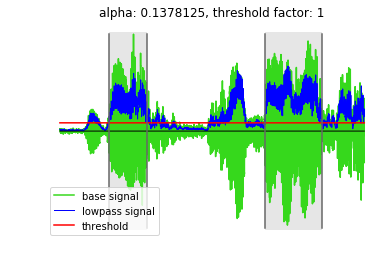

timechunks: 
[[181.41275, 181.536125], [181.924, 182.110625]]
alpha: 0.1378125
Threshold: 0.0063424565857766076


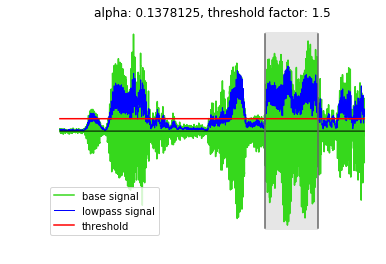

timechunks: 
[[181.92425, 182.099375]]


In [16]:
datasetDir = '../E_SAA_DATA/localizationRecordings/20160919'
filename = datasetDir + '/160919_218_mono1.wav'
fs = 8000
minimalSoundTime = 0.1  # seconds
for alpha in [0.0005, 0.025]: #[0.00005, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05]:
    for thresholdFactor in [1, 1.5]:
        plotSoundChunksWithParams(alpha, thresholdFactor, minimalSoundTime, filename, fsTarget=8000)